<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/3SMILEVAEGenProperty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow==1.12
# !pip install keras==2.2.4

In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-11-02 16:25:34--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-11-02 16:25:34--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | done

## Package Plan ##

In [3]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re

# **SMILES Data Fetching From Zinc Database**

In [4]:
WEIGHTS_FOLDER = 'sample_data/weights/'
smifile = "sample_data/SMILEWithProp.csv"
data = pd.read_csv(smifile, delimiter = ",", header='infer')
NUM_SMILES = len(data)
data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [5]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data, test_size=0.2, shuffle=False)
print(smiles_train.shape)
print(smiles_test.shape)
print(NUM_SMILES)

(1207, 4)
(302, 4)
1509


In [6]:
# print(smiles_train['smiles'])

In [7]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
# print(char_to_int)
print(len(charset), embed)
# print(embed)

40 108


COc1ccc([C@H]2C[C@@H](C(F)(F)F)n3nc(C(=O)NC4CCCCC4)cc3N2)cc1OC



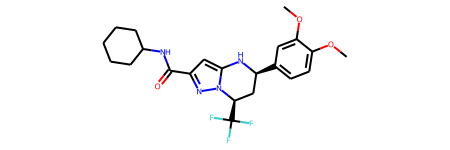

In [8]:
idx=100
print(smiles_train['smiles'][idx])
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles(smiles_train['smiles'][idx])
m

In [9]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train['smiles'].values)
X_test = vectorize(smiles_test['smiles'].values)

(1207, 108, 40)
(302, 108, 40)


In [10]:
# Going back from vectorized form back to a readable string
strr="".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])
print(strr)
print(len(strr))

# String After Tructation of extra symbols

line = re.sub('[!E]', '', strr)
print(len(line))
print(line)

!CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
108
40
CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1



In [11]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
# print(mol_size_x)
# print(mol_size_y)
print(orig_dim)
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
# print(type(X_train))
# print(X_train.shape)
# print(X_train.shape[1])


4320


# **VAE Model Architecture**

In [12]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
import keras
from keras import layers
import tensorflow as tf


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [13]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=20 # Dimension of the latent vector (z)
epochs=50

In [14]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, output_shape=(Z_DIM,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output, name='encoder')

vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                                                                            output_dim = Z_DIM)
# vae_encoder.summary()
# Plot the Encoder Model
plot_model(vae_encoder, to_file='smilesvae_encoder.png', show_shapes=True, show_layer_names=True)  #, expand_nested=True

In [15]:
# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid', name='decoder_lastlayer')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name='decoder')


vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
# vae_decoder.summary()
# Plot the Encoder Model
plot_model(vae_decoder, to_file='smilesvae_decoder.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

In [16]:
def create_predictor_linear():
    '''
    Creates a regressor that estimates digit values 
    from latent variables.
    '''
    predictor_input = layers.Input(shape=(Z_DIM,), name='predictor_input_mean', dtype='float32')
    
    x = layers.Dense(128, activation='relu')(predictor_input)
    x = layers.Dense(1, activation='linear', name='predictor_lastlayer', dtype='float32')(x)

    return Model(predictor_input, x, name='predictor')

In [17]:
# The input to the model will be the smile string fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
# vae_model = Model(vae_input, vae_output)

predictor = create_predictor_linear()
t_predicted = predictor(mean_mu)
vae_model = Model(vae_input, [vae_output,t_predicted], name='composite')


# Plot the Model
plot_model(vae_model, to_file='smilesvae_model.png', show_shapes=True, show_layer_names=True)   #, expand_nested=False

In [18]:
print(mean_mu.shape)

(?, 20)


In [19]:
logP_train = smiles_train['logP']
logP_test = smiles_test['logP']
print(len(logP_train))
print(len(logP_test))

1207
302


In [20]:
print(logP_train[100])

4.6231


In [21]:
# print(mse.get_config())

In [23]:
def vae_loss(vae_input, vae_output):
  reconstruction_loss = binary_crossentropy(vae_input, vae_output)
  reconstruction_loss = reconstruction_loss * orig_dim
    
  kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
  kl_loss = K.sum(kl_loss, axis=-1)    
  kl_loss = kl_loss * -0.5
    
  vae_loss_val = K.mean(reconstruction_loss + kl_loss)
  return vae_loss_val


if __name__ == '__main__':
    models=(vae_encoder, vae_decoder)
    data=(X_test,X_test)

    # reconstruction_loss = binary_crossentropy(vae_input, vae_output)
    # reconstruction_loss = reconstruction_loss * orig_dim
    
    # kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
    # kl_loss = K.sum(kl_loss, axis=-1)    
    # kl_loss = kl_loss * -0.5
    
    # vae_loss = K.mean(reconstruction_loss + kl_loss)
    

    # msee=mse(t_predicted, t_predicted)
  
    # msee=mse(t_predicted, t_predicted)
    losses = [vae_loss, 'mean_squared_error']                    #"mean_squared_error"
              
    lossWeights = [1.0, 2.0]
    # vae_model.add_loss(losses)             #[vae_loss, "mean_squared_error"]
    vae_model.compile(optimizer='adam', 
                      loss=[vae_loss, 'mean_squared_error'], 
                      loss_weights=lossWeights     
                      )  
    
#     Train the Variational AutoEncoder
    history = vae_model.fit(x=X_train,
                            y=[X_train,logP_train], 
                            epochs=epochs,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_test, [X_test, logP_test]),
                            verbose=2
                            )
    vae_model.save_weights('vae_smiles.h5')
    

Train on 1207 samples, validate on 302 samples
Epoch 1/50
 - 20s - loss: 312.3986 - decoder_loss: 307.1830 - predictor_loss: 2.6078 - val_loss: 201.3389 - val_decoder_loss: 198.0383 - val_predictor_loss: 1.6503
Epoch 2/50
 - 20s - loss: 191.1291 - decoder_loss: 188.5331 - predictor_loss: 1.2980 - val_loss: 192.3852 - val_decoder_loss: 190.1428 - val_predictor_loss: 1.1212
Epoch 3/50
 - 18s - loss: 178.5126 - decoder_loss: 176.8474 - predictor_loss: 0.8326 - val_loss: 172.2486 - val_decoder_loss: 171.0440 - val_predictor_loss: 0.6023
Epoch 4/50
 - 18s - loss: 167.4977 - decoder_loss: 166.2963 - predictor_loss: 0.6007 - val_loss: 165.6068 - val_decoder_loss: 164.4084 - val_predictor_loss: 0.5992
Epoch 5/50
 - 18s - loss: 156.3948 - decoder_loss: 155.4965 - predictor_loss: 0.4491 - val_loss: 155.3409 - val_decoder_loss: 154.4062 - val_predictor_loss: 0.4674
Epoch 6/50
 - 19s - loss: 147.3011 - decoder_loss: 146.6249 - predictor_loss: 0.3381 - val_loss: 148.2250 - val_decoder_loss: 147.275

# **Results**

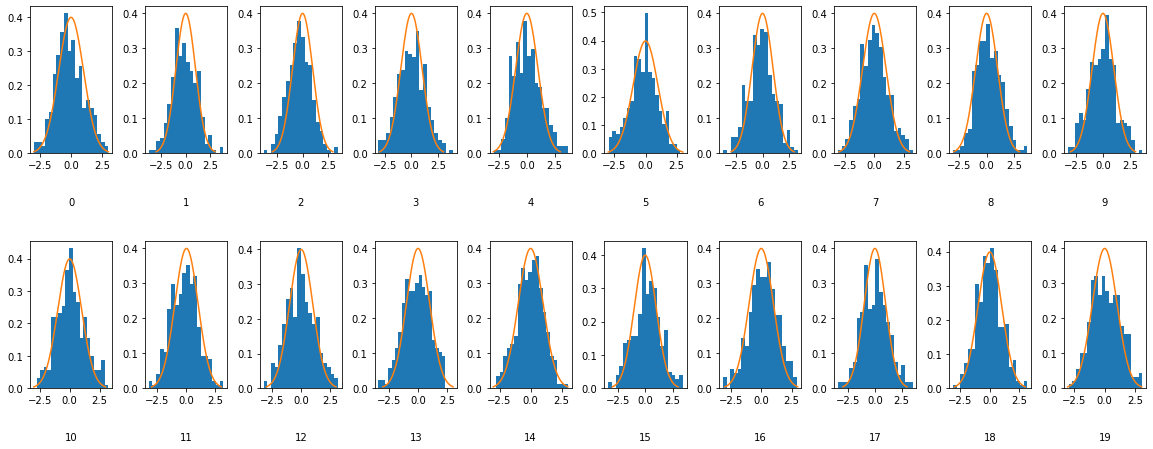

In [28]:
from scipy.stats import norm

z_test = vae_encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

[[ 1.9984876  -0.12253922  1.035501   ...  0.36705714 -0.14157304
  -0.9692061 ]
 [ 0.5972876   0.17661788 -1.0249683  ...  0.14165097 -0.46193078
   1.7623491 ]
 [-1.4626021  -0.23192191 -1.2446105  ... -0.8567755  -0.63405836
   2.0508127 ]
 ...
 [ 1.3053442  -2.5305352  -0.88680136 ...  0.8653339  -1.0050044
  -0.6376116 ]
 [ 0.36613724  0.0238029   1.5704708  ... -1.0096986   0.66001344
   1.6228256 ]
 [-0.26429042  0.3227804  -0.24850199 ...  1.7565618   0.5552778
   0.938694  ]]


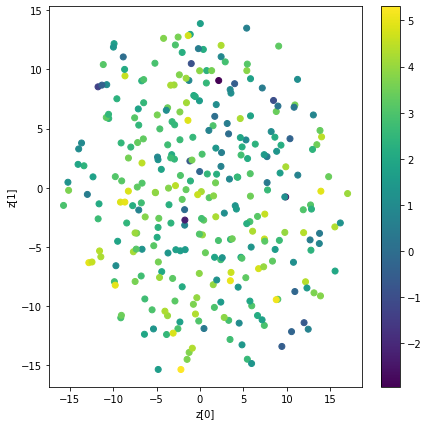

In [39]:
from sklearn.manifold import TSNE
z_mean = vae_encoder.predict(X_test)
print(z_mean)
model_name='VAESMILES_Latent'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "smilesvae_mean.png")

z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=logP_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

# **Reconstruction of Test Molecules**

In [41]:
reconst_Xtest = vae_model.predict(X_test, batch_size=BATCH_SIZE)
print(type(reconst_Xtest))
print(reconst_Xtest[0].shape)
print(X_test.shape)
reconst_test = reconst_Xtest[0].reshape(len(X_test), mol_size_x,mol_size_y)
test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
print(reconst_test[0].shape)
print(test.shape)

<class 'list'>
(302, 4320)
(302, 4320)
(108, 40)
(302, 108, 40)


!COc1ccccc1N1CC[NH+]([C@@H](C)C(=O)Nc2ccc(F)cc2)CC1
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
108
COc1ccccc1N1CC[NH+]([C@@H](C)C(=O)Nc2ccc(F)cc2)CC1

51


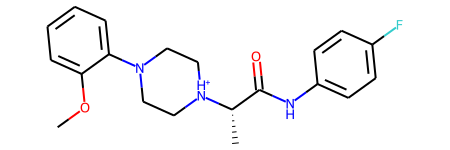

In [43]:
# Going back from vectorized form back to a readable string
idx=200
temp_str="".join([int_to_char[idx] for idx in np.argmax(test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

In [44]:
# Going back from vectorized form back to a readable string
temp_str="".join([int_to_char[idx] for idx in np.argmax(reconst_test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

!CCc1ccccc1N1C[[@H+]([C@@H]1CCC(OO)Nc2ccc(F)cc2CCC1
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
108
CCc1ccccc1N1C[[@H+]([C@@H]1CCC(OO)Nc2ccc(F)cc2CCC1

51


RDKit ERROR: [17:25:12] SMILES Parse Error: syntax error while parsing: CCc1ccccc1N1C[[@H+]([C@@H]1CCC(OO)Nc2ccc(F)cc2CCC1
RDKit ERROR: 
RDKit ERROR: [17:25:12] SMILES Parse Error: Failed parsing SMILES 'CCc1ccccc1N1C[[@H+]([C@@H]1CCC(OO)Nc2ccc(F)cc2CCC1
RDKit ERROR: ' for input: 'CCc1ccccc1N1C[[@H+]([C@@H]1CCC(OO)Nc2ccc(F)cc2CCC1
RDKit ERROR: '


RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: CCn1cCNC(C(=O)[=O)[CCC=OHN2cC1OOcCO)C=)((C)c
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'CCn1cCNC(C(=O)[=O)[CCC=OHN2cC1OOcCO)C=)((C)c' for input: 'CCn1cCNC(C(=O)[=O)[CCC=OHN2cC1OOcCO)C=)((C)c'
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: COC1=](OCcc2c[[@+]](=C2=OCN(C@=O1(cccccccOCC1)C1
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'COC1=](OCcc2c[[@+]](=C2=OCN(C@=O1(cccccccOCC1)C1
RDKit ERROR: ' for input: 'COC1=](OCcc2c[[@+]](=C2=OCN(C@=O1(cccccccOCC1)C1
RDKit ERROR: '
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: CCCCcH]=CC[C@H](CO[C2(C(=OON2)c(C)(CC)c])CC)1O)C
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'CCCCcH]=CC[C@H](CO[C2(C(=OON2)c(C)(CC)c])CC)1O)C
RDKit ERROR: ' for input: 'CCCCcH]=CC[C@H](CO[C2(C(=OON2)c(C)(CC)c])CC)1O)C
RDKit ERROR: '
RDKit ERROR: [17:25:47] SMIL

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: CNCCCC(=O)((C)cccccCnScc(C())=O1@C
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'CNCCCC(=O)((C)cccccCnScc(C())=O1@C' for input: 'CNCCCC(=O)((C)cccccCnScc(C())=O1@C'
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: CCC[(C2O](CNHC(C)(Cc2ccccccc)cnO)CCC()[)O1
RDKit ERROR: 
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'CCC[(C2O](CNHC(C)(Cc2ccccccc)cnO)CCC()[)O1
RDKit ERROR: 
RDKit ERROR: ' for input: 'CCC[(C2O](CNHC(C)(Cc2ccccccc)cnO)CCC()[)O1
RDKit ERROR: 
RDKit ERROR: '
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: Cc1cccC(NCC(=O)N/H]cc/(=c/-c=ccc3cccccF)c(cc)cC1C
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'Cc1cccC(NCC(=O)N/H]cc/(=c/-c=ccc3cccccF)c(cc)cC1C' for input: 'Cc1cccC(NCC(=O)N/H]cc/(=c/-c=ccc3cccccF)c(cc)cC1C'
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: C

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: C[C@H(1CC([C@Hcn(CN3H+])C)CCn)](C3c1nC3cc1ccc1
RDKit ERROR: ))c3)C
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'C[C@H(1CC([C@Hcn(CN3H+])C)CCn)](C3c1nC3cc1ccc1
RDKit ERROR: ))c3)C' for input: 'C[C@H(1CC([C@Hcn(CN3H+])C)CCn)](C3c1nC3cc1ccc1
RDKit ERROR: ))c3)C'
RDKit ERROR: [17:25:47] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(C)C)(c2ccC((C(=O)c(C(CccN)CCCcn)C)nn2)cc1
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(C)C)(c2ccC((C(=O)c(C(CccN)CCCcn)C)nn2)cc1
RDKit ERROR: ' for input: 'Cc1ccc(C)C)(c2ccC((C(=O)c(C(CccN)CCCcn)C)nn2)cc1
RDKit ERROR: '
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: C[C@H]1nCCCNc2ccc(NCHC()[c2cnH]2C[c@(n]ccccc3c[C2C1=C
RDKit ERROR: c1
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'C[C@H]1nCCCNc2ccc(NCHC()[c2cnH]2C[c@(n]ccccc3c[C2C1=C
RDKit ERROR: c1


invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: CC(C)(c(cO)N((C=CH]c(=H](C2nc](C)ccccc)Cc(2C)cc
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'CC(C)(c(cO)N((C=CH]c(=H](C2nc](C)ccccc)Cc(2C)cc' for input: 'CC(C)(c(cO)N((C=CH]c(=H](C2nc](C)ccccc)Cc(2C)cc'
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: COc1ccc(C(=O)((C)NC)cOcccccnc2C(NOCH]C))C
RDKit ERROR: c
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C(=O)((C)NC)cOcccccnc2C(NOCH]C))C
RDKit ERROR: c
RDKit ERROR: ' for input: 'COc1ccc(C(=O)((C)NC)cOcccccnc2C(NOCH]C))C
RDKit ERROR: c
RDKit ERROR: '
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: Cc1ccc(cc(=O)C[CH+CCC[[H@H]2C[(CC@@c]1C[C)n)c2))2
RDKit ERROR: 
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(cc(=O)C[CH+CCC[[H@H]2C[(CC@@c]1C[C)n)c2))2
RDKit ERROR: 
RDKit ERROR: ' for input: 'Cc1ccc(cc(=O)C[CH+CCC[[H@H]2C

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: CCOcO([C@Ns2cc)(C)N2=](C4c@@](s(CC432)C2CC
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'CCOcO([C@Ns2cc)(C)N2=](C4c@@](s(CC432)C2CC
RDKit ERROR: ' for input: 'CCOcO([C@Ns2cc)(C)N2=](C4c@@](s(CC432)C2CC
RDKit ERROR: '
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: COc1ccccC(=O)c(C(=()[Cc(1(cc2nC(=O)/O))c1
RDKit ERROR: 2ncccC
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'COc1ccccC(=O)c(C(=()[Cc(1(cc2nC(=O)/O))c1
RDKit ERROR: 2ncccC' for input: 'COc1ccccC(=O)c(C(=()[Cc(1(cc2nC(=O)/O))c1
RDKit ERROR: 2ncccC'
RDKit ERROR: [17:25:47] SMILES Parse Error: syntax error while parsing: C=C(C](OC(c2cNC(CNC)n)cC1Cc1CCCC[C
RDKit ERROR: 
RDKit ERROR: [17:25:47] SMILES Parse Error: Failed parsing SMILES 'C=C(C](OC(c2cNC(CNC)n)cC1Cc1CCCC[C
RDKit ERROR: ' for input: 'C=C(C](OC(c2cNC(CNC)n)cC1Cc1CCCC[C
RDKit ERROR: '
RDKit ERROR: [17:25:47] SMILES Parse 

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: Nc1cO(N)n](CcC(=O)C[C2@H(cCcccc(cc11)C3c2cc1
RDKit ERROR: 
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'Nc1cO(N)n](CcC(=O)C[C2@H(cCcccc(cc11)C3c2cc1
RDKit ERROR: ' for input: 'Nc1cO(N)n](CcC(=O)C[C2@H(cCcccc(cc11)C3c2cc1
RDKit ERROR: '
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: Cc1cccc(1C(=O)N)C2Cc@H((C)=O)[CCC)C[C@C]]CCC(Ccc1
RDKit ERROR: 
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(1C(=O)N)C2Cc@H((C)=O)[CCC)C[C@C]]CCC(Ccc1
RDKit ERROR: ' for input: 'Cc1cccc(1C(=O)N)C2Cc@H((C)=O)[CCC)C[C@C]]CCC(Ccc1
RDKit ERROR: '
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CCc1ccc(CC@nC(CN)c(cC)c2)cccF)
RDKit ERROR: 2C
RDKit ERROR: 
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'CCc1ccc(CC@nC(CN)c(cC)c2)cccF)
RDKit ERROR: 2C
RDKit ERROR: ' for input: 'CCc1ccc(CC@nC(CN)c(cC)c2)cccF)
RDKit ERROR: 2C
RDKi

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CC[C@@(]1)CcC1@C](C)=c(=(c]c2ccccc(c)2O))21
RDKit ERROR: 
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'CC[C@@(]1)CcC1@C](C)=c(=(c]c2ccccc(c)2O))21
RDKit ERROR: ' for input: 'CC[C@@(]1)CcC1@C](C)=c(=(c]c2ccccc(c)2O))21
RDKit ERROR: '
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CNC(CC(C(=O)cccccc(c)(=2)C11Cnc1CC
RDKit ERROR: CO
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'CNC(CC(C(=O)cccccc(c)(=2)C11Cnc1CC
RDKit ERROR: CO' for input: 'CNC(CC(C(=O)cccccc(c)(=2)C11Cnc1CC
RDKit ERROR: CO'
RDKit ERROR: [17:25:48] SMILES Parse Error: extra close parentheses while parsing: O=C(CCCC)N1Ccc))2cccn2ccccnn2)CCCC
RDKit ERROR: 
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'O=C(CCCC)N1Ccc))2cccn2ccccnn2)CCCC
RDKit ERROR: ' for input: 'O=C(CCCC)N1Ccc))2cccn2ccccnn2)CCCC
RDKit ERROR: '
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CcC@c](OC2ccc/c22NC(=O)N2CC(COcccccc)2)Cc)c=1)C
RDKit ERROR: C
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'CcC@c](OC2ccc/c22NC(=O)N2CC(COcccccc)2)Cc)c=1)C
RDKit ERROR: C' for input: 'CcC@c](OC2ccc/c22NC(=O)N2CC(COcccccc)2)Cc)c=1)C
RDKit ERROR: C'
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CCn1cc([C@H2(COCC)C)Nccccc3+2(C)cOc22cccc1Ncc
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'CCn1cc([C@H2(COCC)C)Nccccc3+2(C)cOc22cccc1Ncc' for input: 'CCn1cc([C@H2(COCC)C)Nccccc3+2(C)cOc22cccc1Ncc'
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: Cc1cc(C)cC(NC=C)C2CCC2nc([ccncc1cC2nC
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C)cC(NC=C)C2CCC2nc([ccncc1cC2nC' for input: 'Cc1cc(C)cC(NC=C)C2CCC2nc([ccncc1cC2nC'
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CCCCCOc(()Nc1CC(=O)c1cC)c1CC

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: Cc11ccn1C(=O)/(C(=NC=C))2ccccccc22)42n)C)cC2ccc1
RDKit ERROR: 
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'Cc11ccn1C(=O)/(C(=NC=C))2ccccccc22)42n)C)cC2ccc1
RDKit ERROR: ' for input: 'Cc11ccn1C(=O)/(C(=NC=C))2ccccccc22)42n)C)cC2ccc1
RDKit ERROR: '
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CcCnC(COC(CC]2c1nc(Cn2(ccccc))2C)[C@@H]
RDKit ERROR: )c1
RDKit ERROR: 
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'CcCnC(COC(CC]2c1nc(Cn2(ccccc))2C)[C@@H]
RDKit ERROR: )c1
RDKit ERROR: ' for input: 'CcCnC(COC(CC]2c1nc(Cn2(ccccc))2C)[C@@H]
RDKit ERROR: )c1
RDKit ERROR: '
RDKit ERROR: [17:25:48] SMILES Parse Error: syntax error while parsing: CCc1ccccccC(cOcc2ccc2)c3[)NnC2C[CC@H]1)Cc2Ccccc2)C1
RDKit ERROR: [17:25:48] SMILES Parse Error: Failed parsing SMILES 'CCc1ccccccC(cOcc2ccc2)c3[)NnC2C[CC@H]1)Cc2Ccccc2)C1' for input: 'CCc1ccccccC(cOcc2ccc2)c3[)NnC2C[CC@H

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:49] SMILES Parse Error: syntax error while parsing: C[CH+=O)c1ccc(cccc()NCCCC[CO))CCCC
RDKit ERROR: 
RDKit ERROR: 
RDKit ERROR: [17:25:49] SMILES Parse Error: Failed parsing SMILES 'C[CH+=O)c1ccc(cccc()NCCCC[CO))CCCC
RDKit ERROR: 
RDKit ERROR: ' for input: 'C[CH+=O)c1ccc(cccc()NCCCC[CO))CCCC
RDKit ERROR: 
RDKit ERROR: '
RDKit ERROR: [17:25:49] SMILES Parse Error: syntax error while parsing: Cc1cC@C(#O)(C1)[@(H)cc1NC(CcCcccOC(CC2O)C)(C)CC
RDKit ERROR: )
RDKit ERROR: [17:25:49] SMILES Parse Error: Failed parsing SMILES 'Cc1cC@C(#O)(C1)[@(H)cc1NC(CcCcccOC(CC2O)C)(C)CC
RDKit ERROR: )' for input: 'Cc1cC@C(#O)(C1)[@(H)cc1NC(CcCcccOC(CC2O)C)(C)CC
RDKit ERROR: )'
RDKit ERROR: [17:25:49] SMILES Parse Error: syntax error while parsing: CC(C)(c1n#n)]11CCCC[N)+]2CC3]2O)ccc23)c3cccC2)cc
RDKit ERROR: 2cc11
RDKit ERROR: 
RDKit ERROR: [17:25:49] SMILES Parse Error: Failed parsing SMILES 'CC(C)(c1n#n)]11CCCC[N)+]2CC3]2O)ccc23)c3cccC2)cc
RDKit ERROR: 2cc11
RDKit ERROR: ' for input: '

invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES
invalid SMILES


RDKit ERROR: [17:25:49] SMILES Parse Error: syntax error while parsing: CnC(C(C)=(C(CCCN[C@H]1(=Occcn+]n1
RDKit ERROR: C=OO3))1C2
RDKit ERROR: [17:25:49] SMILES Parse Error: Failed parsing SMILES 'CnC(C(C)=(C(CCCN[C@H]1(=Occcn+]n1
RDKit ERROR: C=OO3))1C2' for input: 'CnC(C(C)=(C(CCCN[C@H]1(=Occcn+]n1
RDKit ERROR: C=OO3))1C2'
RDKit ERROR: [17:25:49] SMILES Parse Error: syntax error while parsing: C=c1c1c(=O)C2NC(CO[CHc((CO)c()C(=))NC)n1
RDKit ERROR: )C1O
RDKit ERROR: [17:25:49] SMILES Parse Error: Failed parsing SMILES 'C=c1c1c(=O)C2NC(CO[CHc((CO)c()C(=))NC)n1
RDKit ERROR: )C1O' for input: 'C=c1c1c(=O)C2NC(CO[CHc((CO)c()C(=))NC)n1
RDKit ERROR: )C1O'
RDKit ERROR: [17:25:49] SMILES Parse Error: syntax error while parsing: CS1=(=c(C(=Occ2CCC([O)]2CCC=C1
RDKit ERROR: 2C]CC1
RDKit ERROR: C
RDKit ERROR: [17:25:49] SMILES Parse Error: Failed parsing SMILES 'CS1=(=c(C(=Occ2CCC([O)]2CCC=C1
RDKit ERROR: 2C]CC1
RDKit ERROR: C' for input: 'CS1=(=c(C(=Occ2CCC([O)]2CCC=C1
RDKit ERROR: 2C]CC1
RDKit ER

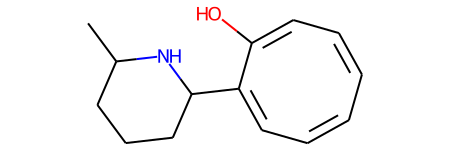

In [45]:
# Generating new Smile Strings sampled from a standard normal distribution
m=None
while m is None:
  reconst_strings = vae_decoder.predict(np.random.normal(0,1,size=(10,Z_DIM)))
  reshaped_string=reconst_strings.reshape(10, mol_size_x, mol_size_y)

  # Going back from vectorized form back to a readable string
  temp_str="".join([int_to_char[idx] for idx in np.argmax(reshaped_string[0,:,:], axis=1)])
  temp_str = re.sub('!|E',"", temp_str)

  m = Chem.MolFromSmiles(temp_str, sanitize=False)
  if m is None:
    print('invalid SMILES')
    continue                   
  else:
    try:
     p = Chem.SanitizeMol(m)
    except:
      print('invalid chemistry') 
m